In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc

In [73]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])

In [74]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands
0,2022-01-01,31,4382.987842,119021.246790,5336
1,2022-01-02,22,-1262.186515,52535.577473,1710
2,2022-01-03,14,2164.049909,23427.252687,1337
3,2022-01-04,11,353.796534,50474.942623,859
4,2022-01-05,14,1293.859597,58254.208463,3150


In [75]:
casino_fig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1097 non-null   datetime64[ns]
 1   Heads        1097 non-null   int64         
 2   Day_Result   1097 non-null   float64       
 3   Total_Bets   1097 non-null   float64       
 4   Total_Hands  1097 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.0 KB


<Axes: xlabel='Date'>

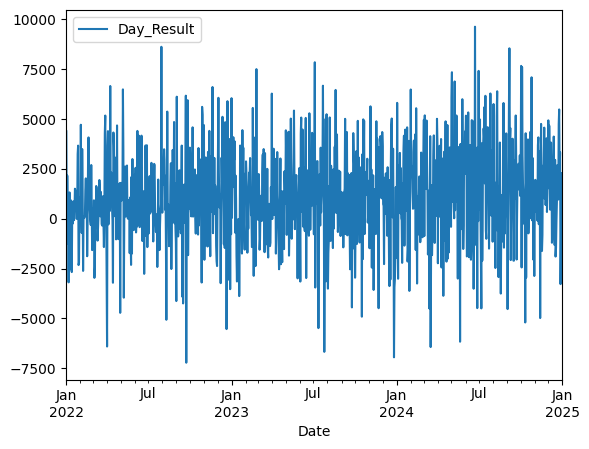

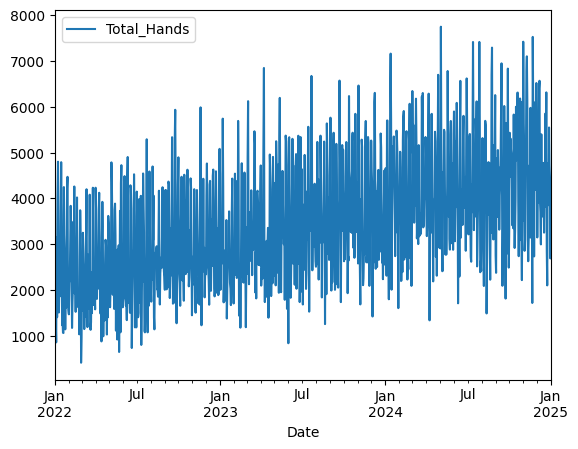

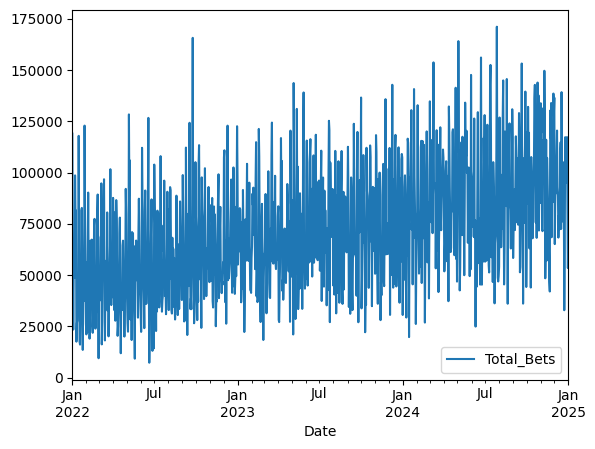

In [76]:
casino_fig[:].plot(x="Date", y ="Day_Result")
casino_fig[:].plot(x="Date", y ="Total_Hands")
casino_fig[:].plot(x="Date", y ="Total_Bets")


In [77]:
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()

<Axes: xlabel='Date'>

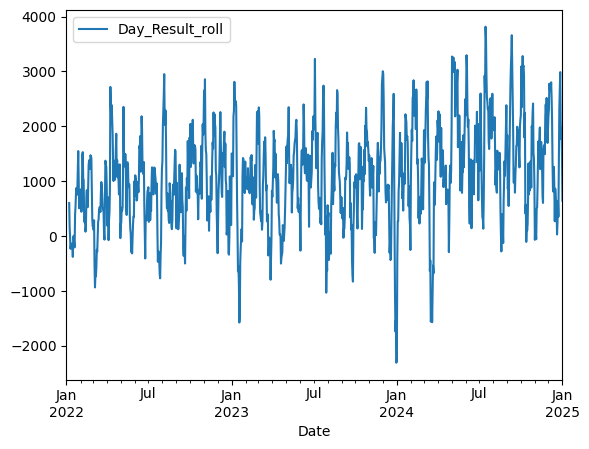

In [78]:
casino_fig.plot(x="Date", y ="Day_Result_roll")

In [79]:
from scipy.signal import medfilt

In [80]:
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=49)

<Axes: xlabel='Date'>

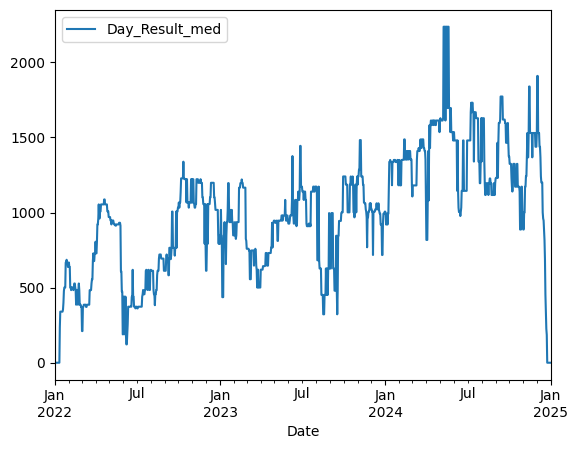

In [81]:
casino_fig.plot(x="Date", y ="Day_Result_med")

In [82]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()


<Axes: xlabel='Date'>

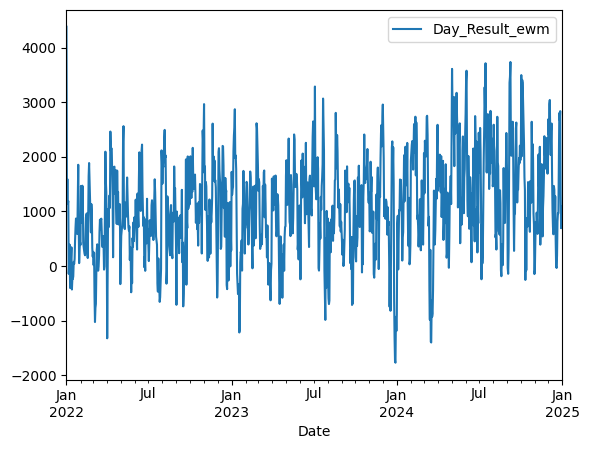

In [83]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [84]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm
0,2022-01-01,31,4382.987842,119021.246790,5336,NaN,0.0,4382.987842
1,2022-01-02,22,-1262.186515,52535.577473,1710,NaN,0.0,1157.173923
2,2022-01-03,14,2164.049909,23427.252687,1337,NaN,0.0,1592.579755
3,2022-01-04,11,353.796534,50474.942623,859,NaN,0.0,1139.539034
4,2022-01-05,14,1293.859597,58254.208463,3150,NaN,0.0,1190.122983


In [85]:
casino_fig['Day_Result_ewm_4'] = casino_fig['Day_Result_ewm'].ewm(span=4, adjust=True).mean()

<Axes: xlabel='Date'>

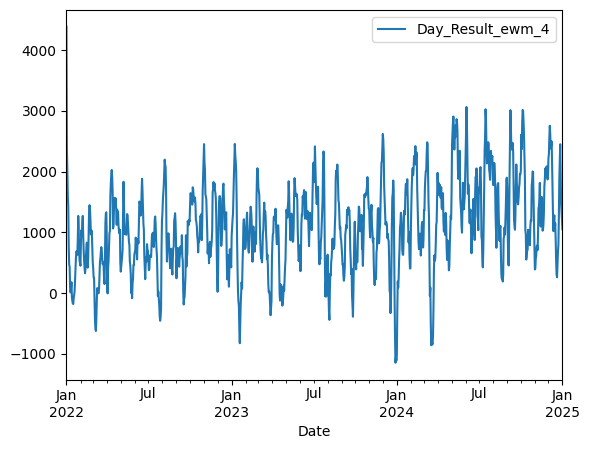

In [86]:
casino_fig.plot(x="Date", y ="Day_Result_ewm_4")

In [87]:
casino_fig['Day_Result_ewm_4_12'] = casino_fig['Day_Result_ewm_4'].ewm(span=72, adjust=True).mean()

<Axes: xlabel='Date'>

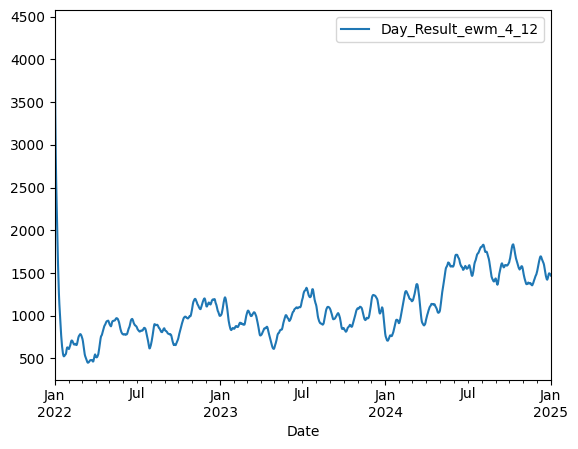

In [88]:
casino_fig.plot(x="Date", y ="Day_Result_ewm_4_12")

In [89]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

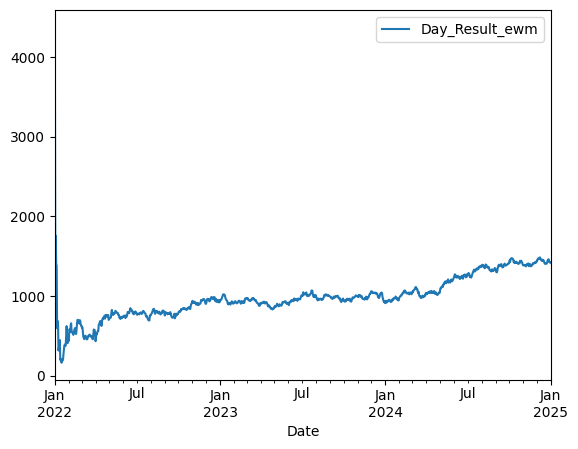

In [90]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [91]:
casino_fig['Total_Bets_ewm'] = casino_fig['Total_Bets'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

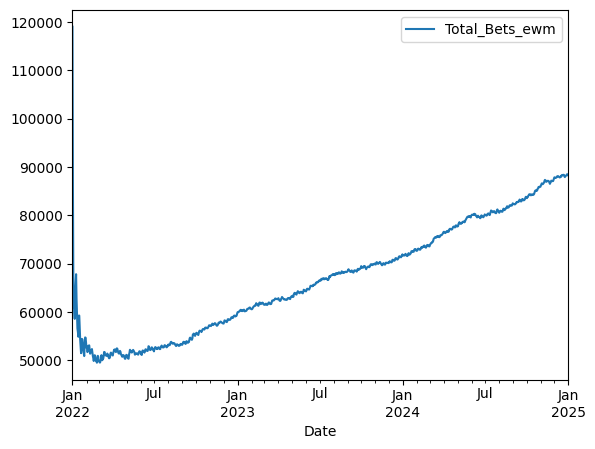

In [92]:
casino_fig.plot(x="Date", y ="Total_Bets_ewm")

In [93]:
from scipy import stats

In [94]:
slope, intercept, r, p, std_err = stats.linregress(casino_fig.index,casino_fig['Total_Bets'])

In [96]:
intercept


np.float64(48595.32265384414)

In [99]:
casino_fig['trend_bet']= slope*casino_fig.index+intercept

<Axes: xlabel='Date'>

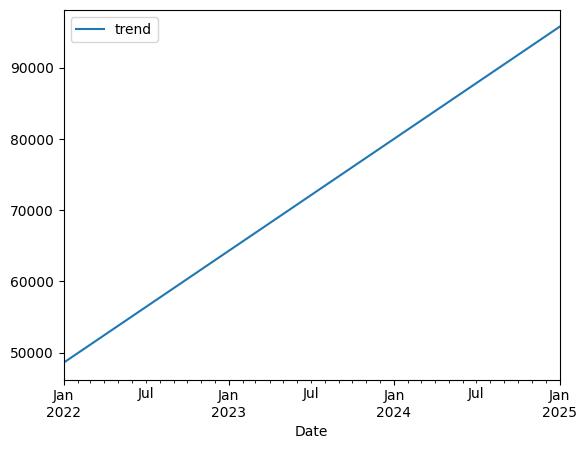

In [100]:
casino_fig.plot(x="Date", y ="trend")

In [101]:
casino_fig['trend_free'] = casino_fig['Total_Bets']-casino_fig['trend_bet']

<Axes: xlabel='Date'>

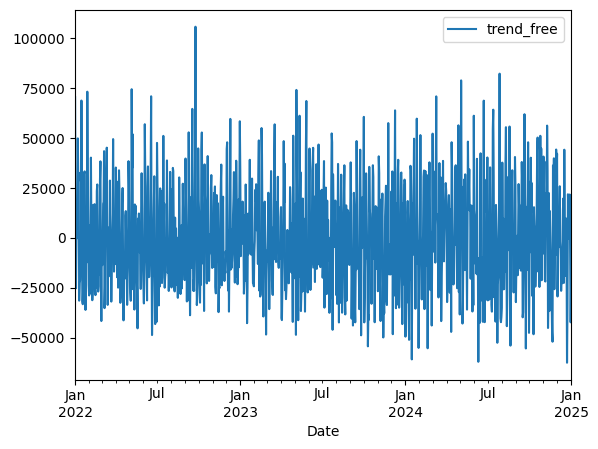

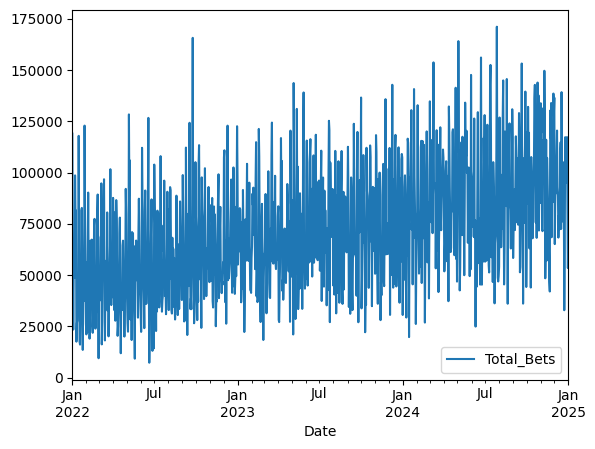

In [103]:
casino_fig.plot(x="Date", y ="trend_free")
casino_fig.plot(x="Date", y ="Total_Bets")